copy from https://github.com/roatienza/Deep-Learning-Experiments/blob/master/Experiments/Tensorflow/GAN/dcgan_mnist.py

copied and edited from:\
https://github.com/dhrim/joongang_2020_03/blob/master/material/deep_learning/dcgan_mnist.ipynb

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.


Using TensorFlow backend.


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5002: [D loss: 0.716653, acc: 0.517578]  [A loss: 0.906224, acc: 0.152344]
5003: [D loss: 0.691183, acc: 0.544922]  [A loss: 0.749155, acc: 0.371094]
5004: [D loss: 0.715685, acc: 0.503906]  [A loss: 0.848521, acc: 0.246094]
5005: [D loss: 0.690072, acc: 0.515625]  [A loss: 0.775552, acc: 0.410156]
5006: [D loss: 0.711962, acc: 0.490234]  [A loss: 0.916112, acc: 0.132812]
5007: [D loss: 0.689901, acc: 0.541016]  [A loss: 0.796294, acc: 0.281250]
5008: [D loss: 0.698812, acc: 0.527344]  [A loss: 0.804688, acc: 0.285156]
5009: [D loss: 0.707080, acc: 0.515625]  [A loss: 0.839435, acc: 0.242188]
5010: [D loss: 0.697445, acc: 0.509766]  [A loss: 0.780664, acc: 0.277344]
5011: [D loss: 0.701295, acc: 0.541016]  [A loss: 0.923683, acc: 0.093750]
5012: [D loss: 0.686839, acc: 0.539062]  [A loss: 0.730517, acc: 0.460938]
5013: [D loss: 0.719583, acc: 0.505859]  [A loss: 1.024627, acc: 0.066406]
5014: [D loss: 0.696483, acc: 0.527344]  [A loss: 0.655538, acc:

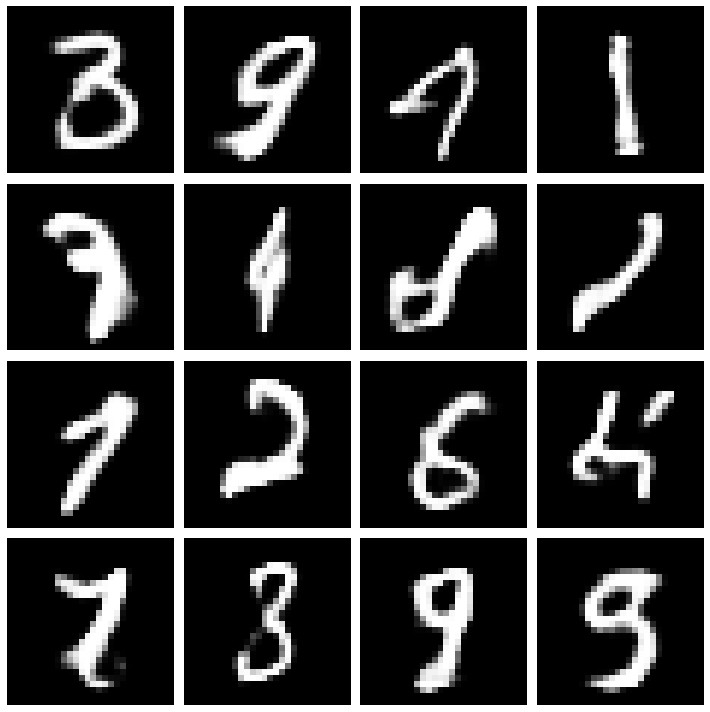

In [2]:
'''
DCGAN on MNIST using Keras
Author: Rowel Atienza
Project: https://github.com/roatienza/Deep-Learning-Experiments
Dependencies: tensorflow 1.0 and keras 2.0
Usage: python3 dcgan_mnist.py
'''

import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel) # 28 x 28 x 1
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same')) # conv2d_5 (Conv2D) (None, 14, 14, 64) 
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same')) # conv2d_6 (Conv2D) (None, 7, 7, 128)
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same')) # conv2d_7 (Conv2D) (None, 4, 4, 256)
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same')) # conv2d_8 (Conv2D) (None, 4, 4, 512)
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten()) # flatten_2 (Flatten) (None, 8192)
        self.D.add(Dense(1)) # dense_3 (Dense) (None, 1)
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100)) # dense_4 (Dense) (None, 12544)
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth))) # reshape_2 (Reshape) (None, 7, 7, 256)
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D()) # up_sampling2d_3 (UpSampling2 (None, 14, 14, 256)
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same')) # conv2d_transpose_5 (Conv2DTr (None, 14, 14, 128)
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())  # up_sampling2d_4 (UpSampling2 (None, 28, 28, 128)
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same')) # conv2d_transpose_6 (Conv2DTr (None, 28, 28, 64)
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same')) # conv2d_transpose_7 (Conv2DTr (None, 28, 28, 32)
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same')) # conv2d_transpose_8 (Conv2DTr (None, 28, 28, 1)
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = input_data.read_data_sets("mnist",\
        	one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows,\
        	self.img_cols, 1).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

mnist_dcgan = MNIST_DCGAN()
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=10000, batch_size=256, save_interval=500)
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)

In [47]:
origin_ = input_data.read_data_sets("mnist", one_hot=True, validation_size=2000).train.images
origin_ = origin_x.reshape(-1, 28, 28, 1).astype(np.float32)
# origin_x = origin_[:2000]

# x_nor = origin_.reshape(1000, 28, 28, 1)
# x_abnor = origin_.reshape(1000, 28, 28, 1)

nor_x = origin_x[:1000]
nor_x = np.ones((1000, 28, 28))
abnor_x = origin_x[1000:]
abnor_x = np.ones((1000, 28, 28))

# 낙서
abnor_x[:, 30:, :] = 255


# # nor_dis = DCGAN.D.predict(nor_x)
# DCGAN.discriminator_model(nor_x)
# # abnor_dis = DCGAN.D.predict(abnor_x)
# DCGAN(origin_).discriminator()
# DCGAN(nor_x).discriminator()
# DCGAN(abnor_x).discriminator_model()

mnist_dcgan.DCGAN.discriminator()(nor_x)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


ValueError: ignored

In [0]:
"""
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4, 4, 256)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 512)         3277312   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8193      
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
=================================================================
Total params: 4,311,553
Trainable params: 4,311,553
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_4 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_5 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_8 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_9 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 64)        204864    
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 32)        51232     
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 1)         801       
_________________________________________________________________
activation_12 (Activation)   (None, 28, 28, 1)         0         
=================================================================
Total params: 2,394,241
Trainable params: 2,368,705
Non-trainable params: 25,536
"""

In [0]:
mnist_dcgan.train(train_steps=10000, batch_size=256, save_interval=500)
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)

In [0]:
mnist_dcgan = MNIST_DCGAN()
timer = ElapsedTimer()

mnist_dcgan.train(train_steps=100000, batch_size=256, save_interval=500)
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)

<케라스 창시자에게 배우는 딥러닝>(길벗, 2018) 를 참고함

#### GAN
- 생성자 네트워크(generator network)\
: 랜덤 벡터(잠재 공간의 무작위한 포인트)를 입력으로 받아 이를 합성한 이미지로 디코딩
 - 잠재 공간은 의미 있는 구조를 보장하지 않으며 연속적이지 않음

- 판별자 네트워크(discriminator network)\
: 상대 네트워크, 이미지(실제 또는 합성 이미지)를 입력받아 훈련 세트에서 온 이미지인지 생성자 네트워크가 만든 이미지인지 판별

- GAN은 최적화의 최솟값이 고정되지 않은 시스템\
: 최적화 과정이 최솟값을 찾는 것이 아니라 두 힘 간의 평정을 찾는 다이나믹 시스템

- GAN을 만드려면 훈련 파라미터를 주의 깊게 조정해야 함

- 생성자의 마지막 활성화로 다른 종류의 모델에 널리 사용하는 sigmoid 대신 tanh함수를 사용
- 균등 분포가 아니고 정규분표(가우시안 분포)를 사용하여 잠재 공간에서 포인트를 샘플링
- 무작위성은 모델을 견고하게 만듦
 - GAN 훈련은 동적 평형을 만들기 때문에 여러 방식으로 갇힐 가능성이 높음
 - 훈련하는 동안 무작위성을 주입하면 이를 방지할 수 있음
 - 무작위성은 판별자에 드롭아웃을 사용하거나 판별자를 위해 레이블에 랜덤 노이즈를 추가함으로써 주입
- 희소한 그래디언트는 GAN 훈련을 방해할 수 있음
 - 최대풀링 연산과 ReLU 활성화 영향
 - 최대풀링 대신 스트라이드 합성곱을 사용하여 다운샘플링하는 것이 좋음
 - ReLU 활성화 대신 LeakyReLU 층을 사용\
 : 음수의 활성화 값을 조금 허용하기 때문에 희소가 조금 완화됨
- 생성자에서 픽셀 공간을 균일하게 다루지 못하여 생성된 이미지에 체스판 모양이 발생할 수 있음
 - 생성자와 판별자에서 스트라이드 Conv2sTranspose나 Conv2D를 사용할 때 스트라이드 크기로 나누어질 수 있는 커널 크기를 사용함
 - 커널 크기가 스트라이드의 배수가 아니면 픽셀이 공평하게 합성곱되지 않음\
 : 커널 크기를 스트라이드를 나누었을 때 나머지 크기에 해당하는 픽셀이 더 많이 업샘플링에 참여하게 됨


#### DCGAN(심층 합성곱)
- 생성자와 판별자가 심층 컨브넷
- 생성자에서 이미지 업샘플링을 위해 Conv2DTranspose층을 사용

- generator 네트워크는 (latent_dim,) 크기의 벡터를 (32, 32, 3) 크기의 이미지로 매핑
- discriminator 네트워크는 (32, 32, 3) 크기의 이미지가 진짜일 확률을 추정하여 이전 값으로 매핑

- 생성자와 판별자를 연결하는 gan 네트워크를 만듦\
gan(x) = discriminator(generator(x))
 - 잠재 공간의 벡터를 판별자의 평가로 매핑함
 - 판별자는 생성자가 잠재 공간의 벡터를 디코딩한 것이 얼마나 현실적인지 평가
- 진짜/가짜 레이블과 함께 진짜 이미지와 가짜 이미지 샘플을 사용하여 판별자를 훈련(일반 이미지 분류 모델 훈련과 동일)
- 생성자를 훈련하려면 gan 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용
 - 단계마다 생성자에 의해 디코딩 이미지를 판별자가 '진짜'로 분류하도록 만드는 방향으로 생성자의 가중치를 이동함(판별자를 속이도록 생성자를 훈련함) 

 - 생성자\
: 백터(훈련하는 동안 잠재 공간에서 무작위로 샘플이된)를 후보 이미지로 변환되는 generator 모델
 - 생성자가 노이즈 같은 이미지를 생성하는 데서 멈추면 판별자와 생성자 양쪽에 모두 드롭아웃 사용

In [0]:
# GAN 생성자 네트워크
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,)) # input_3 (InputLayer) (None, 32)
# 입력을 16x16 크기의 채널 128개를 가진 특성 맵으로 변환
x = layers.Dense(128 * 16 * 16)(generator_input) # dense_6 (Dense) (None, 32768)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x) # reshape_4 (Reshape) (None, 16, 16, 128)

x = layers.Conv2D(256, 5, padding='same')(x) # conv2d_14 (Conv2D) (None, 16, 16, 256)
x = layers.LeakyReLU()(x)

# 32x32 크기로 업샘플링
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x) # conv2d_transpose_11 (Conv2DT (None, 32, 32, 256)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x) # conv2d_58 (Conv2D) (None, 32, 32, 256)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x) # conv2d_59 (Conv2D) (None, 32, 32, 256)
x = layers.LeakyReLU()(x)

# 32x32크기(CIFAR10 이미지 크기)의 1개 채널을 가진 특성맵 생성
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x) # conv2d_60 (Conv2D) (None, 32, 32, 3)

# (latent_dim,) 크기의 입력을 (32, 32, 3) 크기의 이미지로 매핑하는 생성자 모델 객체로 만듦
generator = keras.models.Model(generator_input, x)

generator.summary()

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048

 - 판별자\
후보 이미지(진짜 또는 가짜)를 입력받고 2개의 클래스(생성된 이미지, 훈련 세트에서 온 진짜 이미지)로 분류하는 discriminator 모델

In [0]:
# GAN 판별자 네트워크
discriminator_input = layers.Input(shape=(height, width, channels)) # input_10 (InputLayer) (None, 32, 32, 3)
x = layers.Conv2D(128, 3)(discriminator_input) # conv2d_39 (Conv2D) (None, 30, 30, 128)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x) # conv2d_40 (Conv2D) (None, 14, 14, 128)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x) # conv2d_41 (Conv2D) (None, 6, 6, 128)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x) # conv2d_42 (Conv2D) (None, 2, 2, 128)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x) # flatten_3 (Flatten) (None, 512)

x = layers.Dropout(0.4)(x)
# 분류층
x = layers.Dense(1, activation='sigmoid')(x) # dense_13 (Dense) (None, 1) 

# (32, 32, 3) 크기의 입력을 이진 분류 결정
# 진짜/가짜로 변환하는 판별자 모델 객체를 만듦
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(
    lr=0.0008
    # 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑을 사용
    , clipvalue=1.0
    # 안정된 훈련을 위해 학습률 감쇠를 사용
    , decay=1e-8)

discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0   

- 적대적 네트워크
 - 생성자와 판별자를 연결하여 GAN 설정
 - 훈련할 때 생성자가 판별자를 속이는 능력이 커지도록 학습
 - 잠재 공간의 포인트를 '진짜' 혹은 '가짜'의 분류 결정으로 변환
 - 훈련에 사용되는 타깃 레이블은 항상 '진짜'
 - gan을 훈련하는 것은 discriminator가 가짜 이미지를 보았을 때 진짜라고 예측하도록 만들기 위해 generator의 가중치를 업데이트 하는 것
 - 훈련하는 동안 판별자를 동결(학습되지 않도록 하는 것이 중요)\
 : gan을 훈련할 때 가중치가 업데이트되지 않음, 판별자의 가중치가 훈련하는 동안 업데이트되면 판별자는 항상 '진짜'를 예측하도록 훈련됨

In [0]:
# 적대적 네트워크

# 판별치의 가중치가 훈련되지 않도록 설정(gan 모델에만 적용)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

- 생성 방법
 - 잠재 공간에서 무작위로 포인트를 뽑음(랜덤 노이즈)
 - 랜덤 노이즈를 사용하여 generator에서 이미지 생성
 - 생성된 이미지와 진짜 이미지를 섞음
 - 진짜와 가짜가 섞인 이미지와 이에 대응하는 타깃을 사용하여 discriminator 훈련\
 : 타깃은 '진짜(실제 이미지)' 또는 '가짜(생성된 이미지)
 - 잠재 공간에서 무작위로 새로운 포인트를 뽑음
 - 랜덤 벡터를 사용하여 gan 훈련\
 : 모든 타깃을 '진짜'로 설정, 판별자가 생성된 이미지를 모두 '진짜'라고 예측하도록 생성자의 가중치를 업데이트(gan 안에서 판별자는 동결되기 때문에 생성자만 업데이트함)

In [0]:
# GAN 훈련 구현
import os
from keras.preprocessing import image

# cifar10 로드
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 개구리 이미지 선택(클래스 6)
x_train = x_train[y_train.flatten() == 6]

# 데이터 정규화
x_train = x_train.reshape((x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20

# 생성할 이미지 저장 위치 지정
save_dir = './datasets/gan_images/'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

start = 0
for step in range(iterations):
  # 잠재 공간에서 무작위로 포인트를 생성
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
  
  # 가짜 이미지 디코딩
  generated_images = generator.predict(random_latent_vectors)

  # 진짜 이미지와 연결
  stop = start + batch_size
  real_images = x_train[start: stop]
  combined_images = np.concatenate([generated_images, real_images])
  
  # 진짜 이미지와 가짜 이미지를 구분하여 레이블을 합침
  labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

  # 레이블에 랜덤 노이즈 추가
  labels += 0.05 * np.random.random(labels.shape)

  # discriminator 훈련
  d_loss = discriminator.train_on_batch(combined_images, labels)

  # 잠재 공간에서 무작위로 포인트를 샘플링함
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

  # 모두 '진짜 이미지'라고 레이블을 만듦(사실 거짓임)
  misleading_targets = np.zeros((batch_size, 1))

  # generator를 훈련, 모델에서 discriminator의 가중치는 동결
  a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

  start += batch_size
  if start > len(x_train) - batch_size:
    start = 0
  # 중간에 100step마다 저장하고 그래프를 그림
  if step % 100 ==0:
    # 모델 가중치 저장
    gan.save_weights('gan.h5')
    
    # 측정 지표 출력
    print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
    print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))
    print()

    # 생성된 이미지 1개 저장
    img = image.array_to_img(generated_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

    # 비교를 위해 진짜 이미지 하나 저장
    img = image.array_to_img(real_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


스텝 0에서 판별자 손실: 0.70975006
스텝 0에서 적대적 손실: 0.6708273

스텝 100에서 판별자 손실: 0.64658475
스텝 100에서 적대적 손실: 1.0077914

스텝 200에서 판별자 손실: 0.6960834
스텝 200에서 적대적 손실: 0.85124236

스텝 300에서 판별자 손실: 0.6893279
스텝 300에서 적대적 손실: 0.7591896

스텝 400에서 판별자 손실: 0.69995874
스텝 400에서 적대적 손실: 0.76555425

스텝 500에서 판별자 손실: 0.7043346
스텝 500에서 적대적 손실: 0.75419575

스텝 600에서 판별자 손실: 0.68555754
스텝 600에서 적대적 손실: 0.748706

스텝 700에서 판별자 손실: 0.7247761
스텝 700에서 적대적 손실: 0.82509357

스텝 800에서 판별자 손실: 0.6932297
스텝 800에서 적대적 손실: 0.8840845

스텝 900에서 판별자 손실: 0.6947196
스텝 900에서 적대적 손실: 0.7392045

스텝 1000에서 판별자 손실: 0.70001566
스텝 1000에서 적대적 손실: 0.77537465

스텝 1100에서 판별자 손실: 0.7072772
스텝 1100에서 적대적 손실: 0.7891332

스텝 1200에서 판별자 손실: 0.7142951
스텝 1200에서 적대적 손실: 0.758378

스텝 1300에서 판별자 손실: 0.6866887
스텝 1300에서 적대적 손실: 0.7369658

스텝 1400에서 판별자 손실: 0.6935643
스텝 1400에서 적대적 손실: 0.9063264

스텝 1500에서 판별자 손실: 0.6907934
스텝 1500에서 적대적 손실: 0.72425133

스텝 1600에서 판별자 손실: 0.69391847
스텝 1600에서 적대적 손실: 0.7385324

스텝 1700에서 판별자 손실: 0.6954284
스텝 1700에서 적대적 손실:

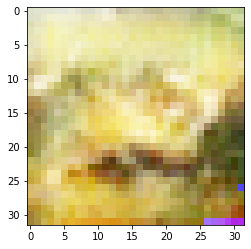

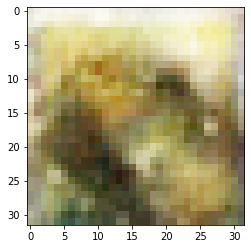

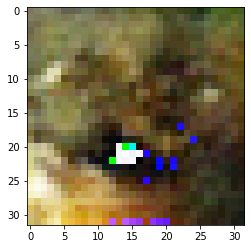

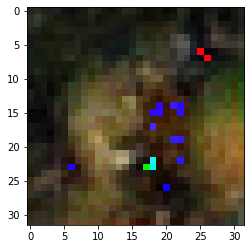

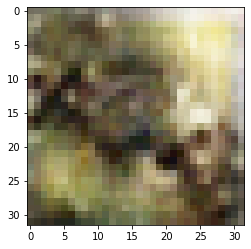

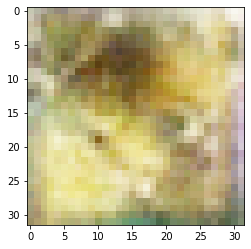

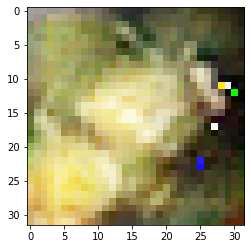

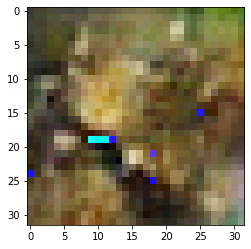

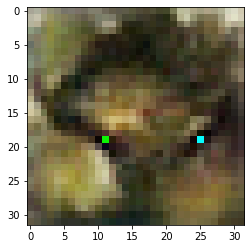

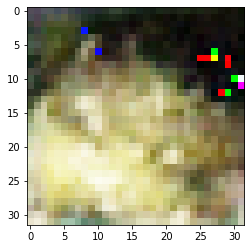

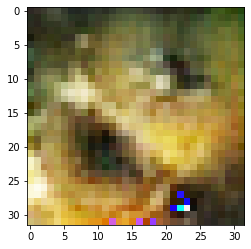

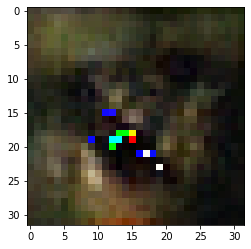

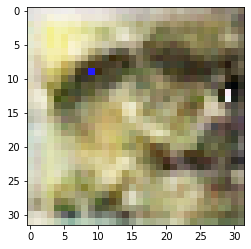

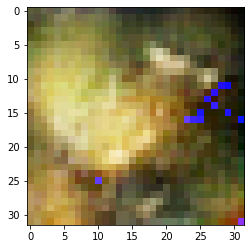

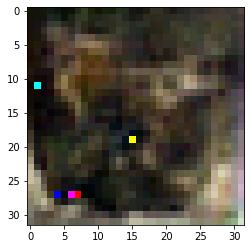

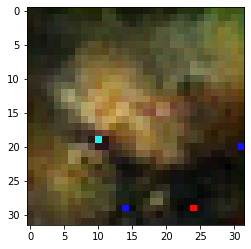

In [0]:
import matplotlib.pyplot as plt

# 잠재 공간에서 랜덤한 포인트를 샘플링
random_latent_vectors = np.random.normal(size=(16, latent_dim))

# 가짜 이미지로 디코딩
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

In [0]:
os.getcwd()

'/content'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
